In [40]:
##processed_data/
##├── water_masks/        # For CNN segmentation
#│   ├── community_water_mask.tif
#│   └── community_ndwi.tif
#├── features/           # For modeling
#│   └── community_features.csv
##├── weather/            # For erosion probability
#│   └── community_weather.json
##├── data_catalog.json   # Master file for next notebooks
##└── processing_summary.json

In [41]:
# Cell 1: Imports and Setup
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List
import requests
from datetime import datetime, timedelta
import json
import os

print("✓ All imports successful!")

✓ All imports successful!


In [42]:
# Cell 2: Weather Data Fetcher Class we are importing real weather data from Open-Meteo API
class WeatherDataFetcher:
    """
    Fetches real weather data from Open-Meteo API (free, no API key required).
    """
    
    def __init__(self):
        self.base_url = "https://api.open-meteo.com/v1/forecast"
        self.marine_url = "https://marine-api.open-meteo.com/v1/marine"
        
    def get_weather_data(self, lat: float, lon: float, 
                         days_forecast: int = 7) -> Dict:
        """
        Get weather data for a location.
        
        Args:
            lat: Latitude
            lon: Longitude
            days_forecast: Number of days to forecast
            
        Returns:
            Dictionary with weather parameters
        """
        params = {
            'latitude': lat,
            'longitude': lon,
            'hourly': ['temperature_2m', 'precipitation', 'windspeed_10m', 
                      'wind_gusts_10m', 'pressure_msl'],
            'forecast_days': days_forecast,
            'timezone': 'America/Anchorage'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching weather data: {e}")
            return None
    
    def get_marine_data(self, lat: float, lon: float,
                       days_forecast: int = 7) -> Dict:
        """
        Get marine/wave data for coastal locations.
        
        Args:
            lat: Latitude
            lon: Longitude
            days_forecast: Number of days to forecast
            
        Returns:
            Dictionary with wave height, direction, period
        """
        params = {
            'latitude': lat,
            'longitude': lon,
            'hourly': ['wave_height', 'wave_direction', 'wave_period',
                      'wind_wave_height', 'wind_wave_direction'],
            'forecast_days': days_forecast,
            'timezone': 'America/Anchorage'
        }
        
        try:
            response = requests.get(self.marine_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching marine data: {e}")
            return None
    
    def calculate_storm_intensity(self, weather_data: Dict) -> float:
        """
        Calculate storm intensity from weather data (0-1 scale).
        """
        if not weather_data or 'hourly' not in weather_data:
            return 0.5  # Default moderate value
        
        hourly = weather_data['hourly']
        
        # Get recent data (last 24 hours)
        wind_speeds = hourly.get('windspeed_10m', [])[-24:]
        wind_gusts = hourly.get('wind_gusts_10m', [])[-24:]
        precipitation = hourly.get('precipitation', [])[-24:]
        
        # Calculate metrics
        avg_wind = np.mean([w for w in wind_speeds if w is not None])
        max_gust = max([g for g in wind_gusts if g is not None], default=0)
        total_precip = sum([p for p in precipitation if p is not None])
        
        # Normalize to 0-1 scale
        wind_factor = min(avg_wind / 30.0, 1.0)
        gust_factor = min(max_gust / 50.0, 1.0)
        precip_factor = min(total_precip / 50.0, 1.0)
        
        # Weighted average
        storm_intensity = (0.4 * wind_factor + 0.4 * gust_factor + 0.2 * precip_factor)
        
        return storm_intensity
    
    def get_wave_height(self, marine_data: Dict) -> float:
        """
        Get average wave height from marine data.
        """
        if not marine_data or 'hourly' not in marine_data:
            return 2.0  # Default moderate value
        
        hourly = marine_data['hourly']
        wave_heights = hourly.get('wave_height', [])[-24:]
        
        # Calculate average wave height
        valid_heights = [h for h in wave_heights if h is not None]
        avg_height = np.mean(valid_heights) if valid_heights else 2.0
        
        return avg_height

print("✓ WeatherDataFetcher class defined!")

✓ WeatherDataFetcher class defined!


In [43]:
# Cell 3: Data Preparation and Cleaning Class
class DataPreparation:
    """
    Handles data cleaning, NDWI calculation, and preparation for CNN/erosion modeling.
    """
    
    def __init__(self, base_path: str):
        """
        Initialize the data preparation class.
        
        Args:
            base_path: Base directory containing tif and geojson files
        """
        self.base_path = Path(base_path)
        self.processed_data = {}
        self.weather_fetcher = WeatherDataFetcher()
        self.weather_cache = {}
        
        # Create output directories
        self.output_dir = self.base_path / "processed_data"
        self.output_dir.mkdir(exist_ok=True)
        
        self.water_masks_dir = self.output_dir / "water_masks"
        self.water_masks_dir.mkdir(exist_ok=True)
        
        self.features_dir = self.output_dir / "features"
        self.features_dir.mkdir(exist_ok=True)
        
        self.weather_dir = self.output_dir / "weather"
        self.weather_dir.mkdir(exist_ok=True)
        
        print(f"✓ Initialized data preparation")
        print(f"  Output directory: {self.output_dir}")

        
        print(f"✓ Initialized data preparation")
        print(f"  Output directory: {self.output_dir}")
    
    def process_tif_to_ndwi(self, tif_path: str, community_name: str, 
                            green_band: int = 2, nir_band: int = 4) -> Dict:
        """
        Process TIF file to calculate NDWI and create water mask.
        
        Args:
            tif_path: Path to the TIF file
            community_name: Name of the community
            green_band: Band index for green (default 2)
            nir_band: Band index for NIR (default 4)
            
        Returns:
            Dictionary with NDWI data, water mask, and metadata
        """
        print(f"\n{'='*50}")
        print(f"Processing: {community_name}")
        print(f"{'='*50}")
        
        with rasterio.open(tif_path) as src:
            # Read bands
            print(f"  Reading bands (Green: {green_band}, NIR: {nir_band})...")
            green = src.read(green_band).astype(float)
            nir = src.read(nir_band).astype(float)
            
            # Calculate NDWI
            print(f"  Calculating NDWI...")
            ndwi = (green - nir) / (green + nir + 1e-10)
            
            # Create water mask
            print(f"  Creating water mask (threshold: NDWI > -0.025)...")
            water_mask = (ndwi > -0.025).astype(np.uint8)

            # Calculate statistics
            total_pixels = water_mask.size
            water_pixels = np.sum(water_mask)
            water_percentage = (water_pixels / total_pixels) * 100
            
            print(f"  Statistics:")
            print(f"    - Total pixels: {total_pixels:,}")
            print(f"    - Water pixels: {water_pixels:,}")
            print(f"    - Water coverage: {water_percentage:.2f}%")
            
            # Store processed data
            result = {
                'ndwi': ndwi,
                'water_mask': water_mask,
                'meta': src.meta,
                'bounds': src.bounds,
                'transform': src.transform,
                'crs': src.crs,
                'shape': water_mask.shape,
                'stats': {
                    'total_pixels': total_pixels,
                    'water_pixels': int(water_pixels),
                    'water_percentage': water_percentage,
                    'ndwi_min': float(np.min(ndwi)),
                    'ndwi_max': float(np.max(ndwi)),
                    'ndwi_mean': float(np.mean(ndwi))
                }
            }
            
            self.processed_data[community_name] = result
            
            return result
    
    def save_water_mask(self, community_name: str) -> str:
        """
        Save water mask as TIF file.
        
        Args:
            community_name: Name of the community
            
        Returns:
            Path to saved file
        """
        if community_name not in self.processed_data:
            raise ValueError(f"No processed data for {community_name}")
        
        data = self.processed_data[community_name]
        output_path = self.water_masks_dir / f"{community_name}_water_mask.tif"
        
        meta = data['meta'].copy()
        meta.update(dtype=rasterio.uint8, count=1)
        
        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(data['water_mask'], 1)
        
        print(f"  ✓ Saved water mask: {output_path}")
        return str(output_path)
    
    def save_ndwi(self, community_name: str) -> str:
        """
        Save NDWI as TIF file for further analysis.
        
        Args:
            community_name: Name of the community
            
        Returns:
            Path to saved file
        """
        if community_name not in self.processed_data:
            raise ValueError(f"No processed data for {community_name}")
        
        data = self.processed_data[community_name]
        output_path = self.water_masks_dir / f"{community_name}_ndwi.tif"
        
        meta = data['meta'].copy()
        meta.update(dtype=rasterio.float32, count=1)
        
        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(data['ndwi'].astype(np.float32), 1)
        
        print(f"  ✓ Saved NDWI: {output_path}")
        return str(output_path)

print("✓ DataPreparation class defined!")

✓ DataPreparation class defined!


In [44]:
# Cell 4: GeoJSON Processing Methods (add to DataPreparation class)

# Cell 4: GeoJSON Processing & Feature Methods (added to DataPreparation class)

def process_geojson(self, geojson_path, community_name):
    """
    Read a shoreline GeoJSON, reproject to a projected CRS (meters),
    and compute area/length/centroid/bounds safely in metric units.
    Also keep original attribute columns (like elevation, unit, etc.).
    """
    import geopandas as gpd
    import pandas as pd

    # Read GeoJSON
    gdf = gpd.read_file(geojson_path)

    # 1) Ensure original CRS is set (most GeoJSON are WGS84)
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")

    # 2) Reproject to projected CRS in meters (Alaska Albers)
    gdf_m = gdf.to_crs(epsg=3338)

    # 3) Compute geometry-based metrics in meters
    geom_stats = pd.DataFrame({
        "area_m2": gdf_m.area,
        "length_m": gdf_m.length,
        "centroid_x": gdf_m.centroid.x,
        "centroid_y": gdf_m.centroid.y,
        "minx": gdf_m.bounds["minx"],
        "miny": gdf_m.bounds["miny"],
        "maxx": gdf_m.bounds["maxx"],
        "maxy": gdf_m.bounds["maxy"],
    })

    # 4) Preserve original non-geometry attributes
    attr_cols = gdf.drop(columns=gdf.geometry.name, errors="ignore")

    # If there are non-geometry columns, join them
    if not attr_cols.empty:
        features = pd.concat([geom_stats.reset_index(drop=True), attr_cols.reset_index(drop=True)], axis=1)
    else:
        features = geom_stats

    # Optional: log something so you see it in the notebook output
    print(f"  - Extracted {len(features)} features")
    print(f"  - Columns: {list(features.columns)}")

    # Store internally
    self.processed_data.setdefault(community_name, {})
    self.processed_data[community_name]["features"] = features

    return features


def save_features_csv(self, community_name, features_df):
    """
    Save the features DataFrame to a CSV in the features directory.
    """
    import pandas as pd

    if features_df is None or not isinstance(features_df, pd.DataFrame):
        raise ValueError("features_df must be a pandas DataFrame")

    output_path = self.features_dir / f"{community_name}_features.csv"
    features_df.to_csv(output_path, index=False)

    print(f"  ✓ Saved features CSV: {output_path}")
    return str(output_path)


# Attach these functions as methods on the existing DataPreparation class
DataPreparation.process_geojson = process_geojson
DataPreparation.save_features_csv = save_features_csv

print("✓ GeoJSON + feature methods added to DataPreparation!")


✓ GeoJSON + feature methods added to DataPreparation!


In [45]:
# Cell 5: Weather Data Collection Methods (add to DataPreparation class)

def fetch_weather_data(self, lat: float, lon: float, 
                      community_name: str) -> Dict:
    """
    Fetch and process weather data for a location.
    
    Args:
        lat: Latitude
        lon: Longitude
        community_name: Name of the community
        
    Returns:
        Dictionary with processed weather data
    """
    cache_key = f"{lat}_{lon}"
    
    # Check cache
    if cache_key in self.weather_cache:
        cached_time, cached_data = self.weather_cache[cache_key]
        if datetime.now() - cached_time < timedelta(hours=1):
            print(f"  Using cached weather data for {community_name}")
            return cached_data
    
    print(f"  Fetching weather data for {community_name}...")
    
    # Fetch weather data
    weather_data = self.weather_fetcher.get_weather_data(lat, lon)
    marine_data = self.weather_fetcher.get_marine_data(lat, lon)
    
    # Calculate parameters
    storm_intensity = self.weather_fetcher.calculate_storm_intensity(weather_data)
    wave_height = self.weather_fetcher.get_wave_height(marine_data)
    
    # Extract additional metrics
    result = {
        'community': community_name,
        'latitude': lat,
        'longitude': lon,
        'timestamp': datetime.now().isoformat(),
        'storm_intensity': storm_intensity,
        'wave_height': wave_height,
    }
    
    # Add hourly data summaries
    if weather_data and 'hourly' in weather_data:
        hourly = weather_data['hourly']
        result.update({
            'avg_wind_speed': np.mean([w for w in hourly.get('windspeed_10m', [])[-24:] if w]),
            'max_wind_gust': max([g for g in hourly.get('wind_gusts_10m', [])[-24:] if g], default=0),
            'total_precipitation': sum([p for p in hourly.get('precipitation', [])[-24:] if p]),
            'avg_temperature': np.mean([t for t in hourly.get('temperature_2m', [])[-24:] if t]),
        })
    
    # Add marine data
    if marine_data and 'hourly' in marine_data:
        hourly = marine_data['hourly']
        result.update({
            'max_wave_height': max([h for h in hourly.get('wave_height', [])[-24:] if h], default=0),
            'avg_wave_period': np.mean([p for p in hourly.get('wave_period', [])[-24:] if p]),
        })
    
    print(f"    - Storm intensity: {storm_intensity:.2f}")
    print(f"    - Wave height: {wave_height:.2f}m")
    
    # Cache the result
    self.weather_cache[cache_key] = (datetime.now(), result)
    
    return result

def save_weather_data(self, weather_data: Dict, community_name: str) -> str:
    """
    Save weather data as JSON and CSV.
    
    Args:
        weather_data: Dictionary with weather data
        community_name: Name of the community
        
    Returns:
        Path to saved files
    """
    # Save as JSON
    json_path = self.weather_dir / f"{community_name}_weather.json"
    with open(json_path, 'w') as f:
        json.dump(weather_data, f, indent=2)
    
    # Save as CSV
    csv_path = self.weather_dir / f"{community_name}_weather.csv"
    df = pd.DataFrame([weather_data])
    df.to_csv(csv_path, index=False)
    
    print(f"  ✓ Saved weather data: {json_path}")
    return str(json_path)

# Add these methods to the DataPreparation class
DataPreparation.fetch_weather_data = fetch_weather_data
DataPreparation.save_weather_data = save_weather_data

print("✓ Weather data collection methods added!")

✓ Weather data collection methods added!


In [46]:
# Cell 6: Visualization Methods (add to DataPreparation class)

def visualize_water_mask(self, community_name: str, save_path: str = None):
    """
    Visualize NDWI and water mask for a community.
    
    Args:
        community_name: Name of the community
        save_path: Optional path to save the figure
    """
    if community_name not in self.processed_data:
        raise ValueError(f"No processed data for {community_name}")
    
    data = self.processed_data[community_name]
    ndwi = data['ndwi']
    water_mask = data['water_mask']
    stats = data['stats']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot NDWI
    im1 = axes[0].imshow(ndwi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0].set_title(f'{community_name} - NDWI\n' + 
                     f'Range: [{stats["ndwi_min"]:.2f}, {stats["ndwi_max"]:.2f}]',
                     fontsize=14)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], label='NDWI Value')
    
    # Plot water mask
    axes[1].imshow(water_mask, cmap='Blues')
    axes[1].set_title(f'{community_name} - Water Mask\n' + 
                     f'Water Coverage: {stats["water_percentage"]:.2f}%',
                     fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved visualization: {save_path}")
    
    plt.show()

def create_summary_report(self, community_name: str) -> pd.DataFrame:
    """
    Create a summary report for a community.
    
    Args:
        community_name: Name of the community
        
    Returns:
        DataFrame with summary statistics
    """
    if community_name not in self.processed_data:
        raise ValueError(f"No processed data for {community_name}")
    
    data = self.processed_data[community_name]
    stats = data['stats']
    
    summary = pd.DataFrame({
        'Metric': [
            'Community Name',
            'Image Shape',
            'Total Pixels',
            'Water Pixels',
            'Land Pixels',
            'Water Coverage (%)',
            'NDWI Min',
            'NDWI Max',
            'NDWI Mean'
        ],
        'Value': [
            community_name,
            str(data['shape']),
            f"{stats['total_pixels']:,}",
            f"{stats['water_pixels']:,}",
            f"{stats['total_pixels'] - stats['water_pixels']:,}",
            f"{stats['water_percentage']:.2f}%",
            f"{stats['ndwi_min']:.3f}",
            f"{stats['ndwi_max']:.3f}",
            f"{stats['ndwi_mean']:.3f}"
        ]
    })
    
    return summary

# Add these methods to the DataPreparation class
DataPreparation.visualize_water_mask = visualize_water_mask
DataPreparation.create_summary_report = create_summary_report

print("✓ Visualization methods added!")

✓ Visualization methods added!


In [47]:
# Cell 7: Main Processing Pipeline

def process_all_communities(self, community_configs: List[Dict], 
                           fetch_weather: bool = True) -> Dict:
    """
    Process all communities and prepare data for CNN/erosion modeling.
    
    Args:
        community_configs: List of dicts with community information
        fetch_weather: Whether to fetch real weather data
        
    Returns:
        Dictionary with summary of processed data
    """
    print("\n" + "="*60)
    print("DATA PREPARATION PIPELINE")
    print("="*60)
    
    summary = {
        'communities': [],
        'total_processed': 0,
        'total_water_pixels': 0,
        'average_water_coverage': 0
    }
    
    for config in community_configs:
        name = config['name']
        
        try:
            # Step 1: Process TIF to NDWI and water mask
            self.process_tif_to_ndwi(
                config['tif_path'], 
                name,
                green_band=config.get('green_band', 2),
                nir_band=config.get('nir_band', 4)
            )
            
            # Step 2: Save water mask and NDWI
            water_mask_path = self.save_water_mask(name)
            ndwi_path = self.save_ndwi(name)
            
            # Step 3: Process GeoJSON if available
            if 'geojson_path' in config and Path(config['geojson_path']).exists():
                geo_df = self.process_geojson(config['geojson_path'], name)
                features_path = self.save_features_csv(name, geo_df)
            else:
                print(f"  ⚠ No GeoJSON file found for {name}")
                features_path = None
            
            # Step 4: Fetch weather data if coordinates provided
            weather_path = None
            if fetch_weather and 'lat' in config and 'lon' in config:
                try:
                    weather_data = self.fetch_weather_data(
                        config['lat'], 
                        config['lon'], 
                        name
                    )
                    weather_path = self.save_weather_data(weather_data, name)
                except Exception as e:
                    print(f"  ⚠ Could not fetch weather: {e}")
            
            # Update summary
            stats = self.processed_data[name]['stats']
            summary['communities'].append({
                'name': name,
                'water_mask_path': water_mask_path,
                'ndwi_path': ndwi_path,
                'features_path': features_path,
                'weather_path': weather_path,
                'water_pixels': stats['water_pixels'],
                'water_percentage': stats['water_percentage']
            })
            summary['total_processed'] += 1
            summary['total_water_pixels'] += stats['water_pixels']
            
            print(f"  ✓ Successfully processed {name}\n")
            
        except Exception as e:
            print(f"  ✗ Error processing {name}: {e}\n")
            continue
    
    # Calculate average water coverage
    if summary['total_processed'] > 0:
        summary['average_water_coverage'] = np.mean([
            c['water_percentage'] for c in summary['communities']
        ])
    
    # Save summary as JSON
    summary_path = self.output_dir / "processing_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total communities processed: {summary['total_processed']}")
    print(f"Average water coverage: {summary['average_water_coverage']:.2f}%")
    print(f"Summary saved to: {summary_path}")
    
    return summary

# Add this method to the DataPreparation class
DataPreparation.process_all_communities = process_all_communities

print("✓ Main processing pipeline added!")

✓ Main processing pipeline added!


In [48]:
# C7.5 use real NDWI-based stats (ignoring nodata/nan) and include them in the summary

import numpy as np
from pathlib import Path
import json

def process_tif_to_ndwi(self, tif_path: str, community_name: str,
                        green_band: int = 2, nir_band: int = 4) -> dict:
    """
    Replaces the original method.
    - Computes NDWI using only valid pixels.
    - Calculates water mask and NDWI statistics on valid pixels only.
    """
    tif_path = Path(tif_path)

    print(f"\n{'='*50}")
    print(f"Processing: {community_name}")
    print(f"{'='*50}")
    print(f"  TIF path: {tif_path}")

    if not tif_path.exists():
        raise FileNotFoundError(f"TIF file not found: {tif_path}")

    with rasterio.open(tif_path) as src:
        print(f"  CRS: {src.crs}")
        print(f"  Shape: {src.height} x {src.width}")
        print(f"  Reading bands (Green: {green_band}, NIR: {nir_band})...")

        # Read as masked arrays so nodata is handled correctly
        green = src.read(green_band, masked=True).astype("float32")
        nir   = src.read(nir_band,   masked=True).astype("float32")

        # Valid where both bands are present
        valid_mask = (~green.mask) & (~nir.mask)

        # Avoid division by zero
        denom = green + nir
        valid_mask &= (denom != 0)

        # Allocate NDWI as full array, NaN outside valid pixels
        ndwi = np.full(green.shape, np.nan, dtype="float32")
        ndwi[valid_mask] = (green[valid_mask] - nir[valid_mask]) / (
            denom[valid_mask] + 1e-10
        )

        # Water mask from NDWI
        threshold = -0.05  # change this if you want stricter water definition
        print(f"  Creating water mask (threshold: NDWI > {threshold})...")
        water_mask = np.zeros_like(ndwi, dtype=np.uint8)
        water_mask[valid_mask & (ndwi > threshold)] = 1

        # Stats on VALID NDWI pixels only
        valid_ndwi = ndwi[valid_mask & np.isfinite(ndwi)]

        total_pixels = int(valid_ndwi.size)
        water_pixels = int(np.sum(water_mask[valid_mask & np.isfinite(ndwi)]))
        water_percentage = (water_pixels / total_pixels * 100) if total_pixels > 0 else 0.0

        if total_pixels > 0:
            ndwi_min = float(np.nanmin(valid_ndwi))
            ndwi_max = float(np.nanmax(valid_ndwi))
            ndwi_mean = float(np.nanmean(valid_ndwi))
        else:
            ndwi_min = ndwi_max = ndwi_mean = float("nan")

        print("  Statistics (valid NDWI pixels only):")
        print(f"    - Total valid pixels: {total_pixels:,}")
        print(f"    - Water pixels:      {water_pixels:,}")
        print(f"    - Water coverage:    {water_percentage:.2f}%")
        print(f"    - NDWI min:          {ndwi_min:.3f}")
        print(f"    - NDWI max:          {ndwi_max:.3f}")
        print(f"    - NDWI mean:         {ndwi_mean:.3f}")

        result = {
            "ndwi": ndwi,
            "water_mask": water_mask,
            "meta": src.meta,
            "bounds": src.bounds,
            "transform": src.transform,
            "crs": src.crs,
            "shape": water_mask.shape,
            "stats": {
                "total_pixels": total_pixels,      # valid NDWI pixels
                "water_pixels": water_pixels,
                "water_percentage": water_percentage,
                "ndwi_min": ndwi_min,
                "ndwi_max": ndwi_max,
                "ndwi_mean": ndwi_mean,
            },
        }

    self.processed_data[community_name] = result
    return result


def process_all_communities(self, community_configs, fetch_weather: bool = True) -> dict:
    """
    Updated pipeline:
    - Uses the patched NDWI function above.
    - Saves NDWI stats into processing_summary.json for each community.
    """
    print("\n" + "="*60)
    print("DATA PREPARATION PIPELINE")
    print("="*60)

    summary = {
        "communities": [],
        "total_processed": 0,
        "total_water_pixels": 0,
        "average_water_coverage": 0.0,
        "average_ndwi_min": None,
        "average_ndwi_max": None,
        "average_ndwi_mean": None,
    }

    for config in community_configs:
        name = config["name"]
        print(f"\n--- {name.upper()} ---")

        try:
            # Step 1: NDWI + water mask
            self.process_tif_to_ndwi(
                config["tif_path"],
                name,
                green_band=config.get("green_band", 2),
                nir_band=config.get("nir_band", 4),
            )

            # Step 2: Save water mask and NDWI
            water_mask_path = self.save_water_mask(name)
            ndwi_path = self.save_ndwi(name)

            # Step 3: GeoJSON, if available
            features_path = None
            if "geojson_path" in config and Path(config["geojson_path"]).exists():
                geo_df = self.process_geojson(config["geojson_path"], name)
                features_path = self.save_features_csv(name, geo_df)
            else:
                print(f"  ⚠ No GeoJSON file found for {name}")

            # Step 4: Weather, if requested
            weather_path = None
            if fetch_weather and "lat" in config and "lon" in config:
                try:
                    weather_data = self.fetch_weather_data(
                        config["lat"], config["lon"], name
                    )
                    weather_path = self.save_weather_data(weather_data, name)
                except Exception as e:
                    print(f"  ⚠ Could not fetch weather: {e}")

            stats = self.processed_data[name]["stats"]

            summary["communities"].append(
                {
                    "name": name,
                    "water_mask_path": water_mask_path,
                    "ndwi_path": ndwi_path,
                    "features_path": features_path,
                    "weather_path": weather_path,
                    "total_pixels": stats["total_pixels"],
                    "water_pixels": stats["water_pixels"],
                    "water_percentage": stats["water_percentage"],
                    "ndwi_min": stats["ndwi_min"],
                    "ndwi_max": stats["ndwi_max"],
                    "ndwi_mean": stats["ndwi_mean"],
                }
            )

            summary["total_processed"] += 1
            summary["total_water_pixels"] += stats["water_pixels"]

            print(f"  ✓ Successfully processed {name}")

        except Exception as e:
            print(f"  ✗ Error processing {name}: {e}")
            continue

    # Averages across all successfully processed communities
    if summary["total_processed"] > 0:
        summary["average_water_coverage"] = float(
            np.mean([c["water_percentage"] for c in summary["communities"]])
        )
        summary["average_ndwi_min"] = float(
            np.mean([c["ndwi_min"] for c in summary["communities"]])
        )
        summary["average_ndwi_max"] = float(
            np.mean([c["ndwi_max"] for c in summary["communities"]])
        )
        summary["average_ndwi_mean"] = float(
            np.mean([c["ndwi_mean"] for c in summary["communities"]])
        )

    # Save summary as JSON
    summary_path = self.output_dir / "processing_summary.json"
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=2)

    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total communities processed: {summary['total_processed']}")
    print(f"Average water coverage: {summary['average_water_coverage']:.2f}%")
    if summary["total_processed"] > 0:
        print(
            f"Average NDWI mean across communities: {summary['average_ndwi_mean']:.3f}"
        )
    print(f"Summary saved to: {summary_path}")

    return summary


# Override the old methods on the class
DataPreparation.process_tif_to_ndwi = process_tif_to_ndwi
DataPreparation.process_all_communities = process_all_communities

print("✓ Updated NDWI stats + processing summary to use real NDWI values")


✓ Updated NDWI stats + processing summary to use real NDWI values


In [49]:
# Cell 8: Example Usage - Process Your Communities

# Set your base path
base_path = r"C:\CAEE Hackthon"

# Initialize data preparation
data_prep = DataPreparation(base_path)

# Define your communities with coordinates
communities = [
    {
        'name': 'quinhagak',
        'tif_path': f'{base_path}/Dataset stuffs/quinhagak_lagoon_buffer_1_5km.tif',
        'geojson_path': f'C:\CAEE Hackthon\Dataset stuffs\elevation\quinhagak_elevation.geojson',  # Optional
        'lat': 59.7556,
        'lon': -161.9161,
        'green_band': 2,  # Adjust if needed
        'nir_band': 4     # Adjust if needed
    },
    # Add more communities here:
    # {
    #     'name': 'Kotzbue',
    #     'tif_path': f'{base_path}/kotzbue.tif',
    #     'lat': 67.7361,
    #     'lon': -164.5436,
    #     'green_band': 2,
    #     'nir_band': 4
    # },
]

# Run the processing pipeline
summary = data_prep.process_all_communities(
    communities, 
    fetch_weather=True  # Set to False if you don't want weather data
)

print("\n✓ All data prepared and saved!")

✓ Initialized data preparation
  Output directory: C:\CAEE Hackthon\processed_data
✓ Initialized data preparation
  Output directory: C:\CAEE Hackthon\processed_data

DATA PREPARATION PIPELINE

--- QUINHAGAK ---

Processing: quinhagak
  TIF path: C:\CAEE Hackthon\Dataset stuffs\quinhagak_lagoon_buffer_1_5km.tif
  CRS: EPSG:4326
  Shape: 290 x 388
  Reading bands (Green: 2, NIR: 4)...
  Creating water mask (threshold: NDWI > -0.05)...
  Statistics (valid NDWI pixels only):
    - Total valid pixels: 105,667
    - Water pixels:      30,451
    - Water coverage:    28.82%
    - NDWI min:          -0.495
    - NDWI max:          0.255
    - NDWI mean:         -0.162
  ✓ Saved water mask: C:\CAEE Hackthon\processed_data\water_masks\quinhagak_water_mask.tif
  ✓ Saved NDWI: C:\CAEE Hackthon\processed_data\water_masks\quinhagak_ndwi.tif
  - Extracted 35 features
  - Columns: ['area_m2', 'length_m', 'centroid_x', 'centroid_y', 'minx', 'miny', 'maxx', 'maxy', 'generated', 'unit', 'elevation']
  ✓

  ✓ Saved visualization: C:\CAEE Hackthon\processed_data\quinhagak_visualization.png


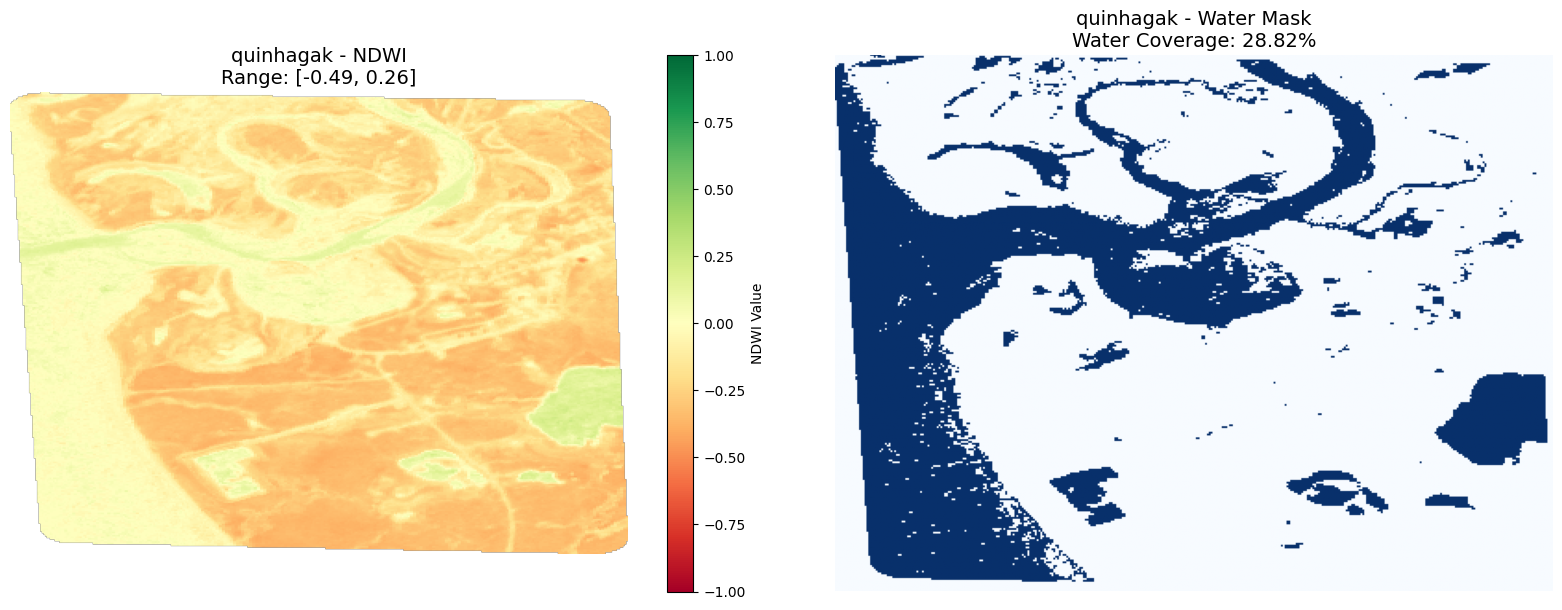


QUINHAGAK SUMMARY:
            Metric      Value
    Community Name  quinhagak
       Image Shape (290, 388)
      Total Pixels    105,667
      Water Pixels     30,451
       Land Pixels     75,216
Water Coverage (%)     28.82%
          NDWI Min     -0.495
          NDWI Max      0.255
         NDWI Mean     -0.162



In [50]:
# Cell 9: Visualize Results for Each Community

# Visualize water masks for all processed communities
for community_name in data_prep.processed_data.keys():
    save_path = data_prep.output_dir / f"{community_name}_visualization.png"
    data_prep.visualize_water_mask(community_name, save_path=str(save_path))
    
    # Display summary report
    summary_df = data_prep.create_summary_report(community_name)
    print(f"\n{community_name.upper()} SUMMARY:")
    print(summary_df.to_string(index=False))
    print()

In [51]:
# Cell 10: Export Metadata for CNN and Erosion Modeling Notebooks

# Create a master data catalog for the next notebooks
data_catalog = {
    'base_path': str(data_prep.base_path),
    'output_dir': str(data_prep.output_dir),
    'communities': {}
}

for community_name, data in data_prep.processed_data.items():
    data_catalog['communities'][community_name] = {
        'water_mask_path': str(data_prep.water_masks_dir / f"{community_name}_water_mask.tif"),
        'ndwi_path': str(data_prep.water_masks_dir / f"{community_name}_ndwi.tif"),
        'features_csv': str(data_prep.features_dir / f"{community_name}_features.csv"),
        'weather_json': str(data_prep.weather_dir / f"{community_name}_weather.json"),
        'shape': data['shape'],
        'stats': data['stats']
    }

# Save catalog
catalog_path = data_prep.output_dir / "data_catalog.json"
with open(catalog_path, 'w') as f:
    json.dump(data_catalog, f, indent=2)

print("="*60)
print("DATA CATALOG CREATED")
print("="*60)
print(f"Catalog saved to: {catalog_path}")
print("\nThis catalog contains paths to all processed data:")
print("  - Water masks (for CNN image segmentation)")
print("  - NDWI rasters (for analysis)")
print("  - Feature CSVs (for modeling)")
print("  - Weather data (for erosion probability)")
print("\nUse this catalog in your next notebooks:")
print("  1. CNN Image Segmentation Notebook")
print("  2. Erosion Probability Modeling Notebook")
print("\n✓ Ready for next steps!")

DATA CATALOG CREATED
Catalog saved to: C:\CAEE Hackthon\processed_data\data_catalog.json

This catalog contains paths to all processed data:
  - Water masks (for CNN image segmentation)
  - NDWI rasters (for analysis)
  - Feature CSVs (for modeling)
  - Weather data (for erosion probability)

Use this catalog in your next notebooks:
  1. CNN Image Segmentation Notebook
  2. Erosion Probability Modeling Notebook

✓ Ready for next steps!
